In [5]:
# Source
# https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-fa-model-selection-py

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Generate data

In [6]:
n_samples, n_features, rank = 1000, 50, 10
sigma = 1.
rng = np.random.RandomState(42)

# U, V are orthogonal matrix
# can only perform svd based on a square matrix
U,Eigen, V = linalg.svd(rng.randn(n_features, n_features))

# X is generated using 10
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)
X.shape # (n_samples * rank) * ( rank * n_features)

(1000, 50)

In [7]:
print(U.shape, V.shape)
# Check Random
print(np.allclose(U, U.T))
print(np.allclose(V, V.T))
print(np.allclose(0.0, np.sum(U[:,0]*U[:,1]))) # check orthogonal
print(np.allclose(1.0, np.sum(U[:,0]*U[:,0]))) # check length =1 

tmp = np.dot(U.T, U)
print(np.allclose(tmp, np.identity(len(tmp)))) # check idempotent
# The inverse is the transpose

tmp = np.dot(V.T, V)
print(np.allclose(tmp, np.identity(len(tmp)))) # check idempotent
# The inverse is the transpose

(50, 50) (50, 50)
False
False
True
True
True
True


In [8]:
display(X.shape)
display(np.cov(X))

(1000, 50)

array([[ 0.34701604, -0.01675572,  0.04559079, ..., -0.02386514,
         0.04174825,  0.14968296],
       [-0.01675572,  0.12993346,  0.02230369, ...,  0.06488564,
        -0.09364157, -0.01490318],
       [ 0.04559079,  0.02230369,  0.33195661, ...,  0.02123722,
        -0.04636316,  0.04260047],
       ...,
       [-0.02386514,  0.06488564,  0.02123722, ...,  0.18253529,
        -0.06566432,  0.02417432],
       [ 0.04174825, -0.09364157, -0.04636316, ..., -0.06566432,
         0.12184334, -0.01045608],
       [ 0.14968296, -0.01490318,  0.04260047, ...,  0.02417432,
        -0.01045608,  0.13794554]])

In [9]:
# Adding heteroscedastic noise
# the variance is different according to different feature
sigmas = 1.5 * sigma * rng.rand(n_features)
# sigmas = sigma * rng.rand(n_features) + sigma/2.
# Note: sigmas is only one row. This is not dot multiplication
# np will broadcast sigma across multiple rows
X_hetero = X + rng.randn(n_samples, n_features) * sigmas
display(sigmas.shape)

(50,)

In [10]:
# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# this is equivalent to:
X_homo2 = X + rng.randn(n_samples, n_features) * ([sigma] * n_features)
display(X_homo.shape)
display(np.cov(X_homo))

(1000, 50)

array([[ 0.99168318,  0.07589368,  0.15494171, ...,  0.1803387 ,
         0.1055484 ,  0.43011611],
       [ 0.07589368,  1.61943577, -0.0032002 , ..., -0.05462463,
         0.17316151,  0.12637941],
       [ 0.15494171, -0.0032002 ,  1.45390162, ...,  0.1736414 ,
         0.26899809,  0.04540163],
       ...,
       [ 0.1803387 , -0.05462463,  0.1736414 , ...,  1.0306521 ,
         0.09036488,  0.13504893],
       [ 0.1055484 ,  0.17316151,  0.26899809, ...,  0.09036488,
         0.90561232,  0.0883819 ],
       [ 0.43011611,  0.12637941,  0.04540163, ...,  0.13504893,
         0.0883819 ,  0.97734624]])

In [11]:
# n_components is: 5,10, 15, ...
n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    '''
    using PCA and Factor analysis for cross validation
    using function cross_validation_score
    '''
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X,cv=5)))
        fa_scores.append(np.mean(cross_val_score(fa, X, cv=5)))

    return pca_scores, fa_scores

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X, cv=5))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

In [12]:
#  Test the cross_val_score
pca = PCA(svd_solver='full')
pca.n_components = 3
pca.fit(X_homo)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [13]:
# Likely the score is taken from here:
# https://rdrr.io/bioc/pcaMethods/man/Q2.html
cross_val_score(pca, X_homo, cv=3)

array([-75.37156775, -75.50039677, -74.79789461])

In [14]:
X_homo.shape

(1000, 50)

# Print out the score of each fold

In [15]:
# Simple test
pca_3 = PCA(svd_solver='full')
pca_3.n_components = 10

pca_5 = PCA(svd_solver='full')
pca_5.n_components = 50

# Not too much difference. What does this mean?
print(cross_val_score(pca_3, X_homo, cv=5))
print(cross_val_score(pca_5, X_homo, cv=5))

[-74.41992831 -75.35878047 -74.6755041  -74.30186295 -74.09197609]
[-75.00605902 -76.0467178  -75.31542054 -74.6462431  -74.70284458]


Using Homoscedastic Noise
best n_components by PCA CV = 10
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 10
Using Heteroscedastic Noise
best n_components by PCA CV = 45
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 49


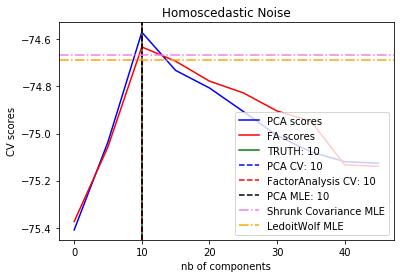

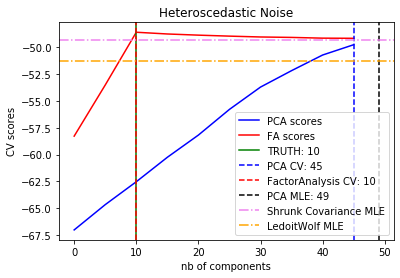

In [16]:
for X, title in [(X_homo, 'Homoscedastic Noise'),
                 (X_hetero, 'Heteroscedastic Noise')]:
    # compute scores of each model using multiple choices of n_components
    pca_scores, fa_scores = compute_scores(X)
    
    # Take the best components
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]
    
    # Alternatively: guessing n_components using mle
    pca = PCA(svd_solver='full', n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("Using %s"% title)
    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
    plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X), color='orange',
                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()

In [17]:
# For more info on Shrinkage Covariance
# https://scikit-learn.org/stable/auto_examples/covariance/plot_covariance_estimation.html#sphx-glr-auto-examples-covariance-plot-covariance-estimation-py